In [99]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra

import wandb

from data.dataManager import DataManager
from model.modelCreator import ModelCreator
from omegaconf import OmegaConf
from scripts.run import setup_model, load_model_instance

from scripts.run import set_device

from model.rbm.rbm_two_partite import RBM_TwoPartite

In [100]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="CaloQuVAE/config")
config=compose(config_name="config.yaml")
wandb.init(tags = [config.data.dataset_name], project=config.wandb.project, entity=config.wandb.entity, config=OmegaConf.to_container(config, resolve=True), mode='disabled')

In [101]:
new_model = False
if new_model:
    self = setup_model(config)
    # self.model = self.model.double()  # sets all model parameters to float64
else:
    self = load_model_instance(config)
    # self.model = self.model.double()


[16:39:43.090] INFO   data.dataManager                                  Loading ATLAS dataset: AtlasReg000New
[16:39:45.716] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fb2208ce6c0>: 119999 events, 118 batches
[16:39:45.719] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fb2208922a0>: 15001 events, 15 batches
[16:39:45.721] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fb2110053d0>: 14999 events, 15 batches
[16:39:45.722] INFO   model.modelCreator                                ::Creating Model
[16:39:45.959] INFO   scripts.run                                       Requesting GPUs. GPU list :[2]
[16:39:45.961] INFO   scripts.run                                       Main GPU : cuda:2
[16:39:45.962] INFO   scripts.run                                       CUDA available
[16:39:46.003] INFO   model

cuda:2
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _bce_loss
Loading weights for module =  encoder
Loading weights for module =  decoder
Loading weights for module =  prior


[16:39:46.207] INFO   model.modelCreator                                Loaded VAE optimizer state


In [102]:
self.evaluate_vae(self.data_mgr.val_loader,0)

[16:40:17.126] INFO   engine.engine                                     Epoch: 0 - Average Val Loss: 5655.6582


{'val_ae_loss': 5338.858569335937,
 'val_hit_loss': 316.79974466959635,
 'val_entropy': -4.8685050964355465,
 'val_pos_energy': -0.1304865482573708,
 'val_loss': 5655.658227539063}

In [103]:
cfg = OmegaConf.load(config.rbm_config_path)
cfg.gpu_list = config.gpu_list
rbm = RBM_TwoPartite(cfg)
rbm.params["weight_matrix"] = torch.load(cfg.weights_path)
rbm.params["vbias"] = torch.load(cfg.vbias_path)
rbm.params["hbias"] = torch.load(cfg.hbias_path)
rbm_samples = torch.load(cfg.samples_data_path)

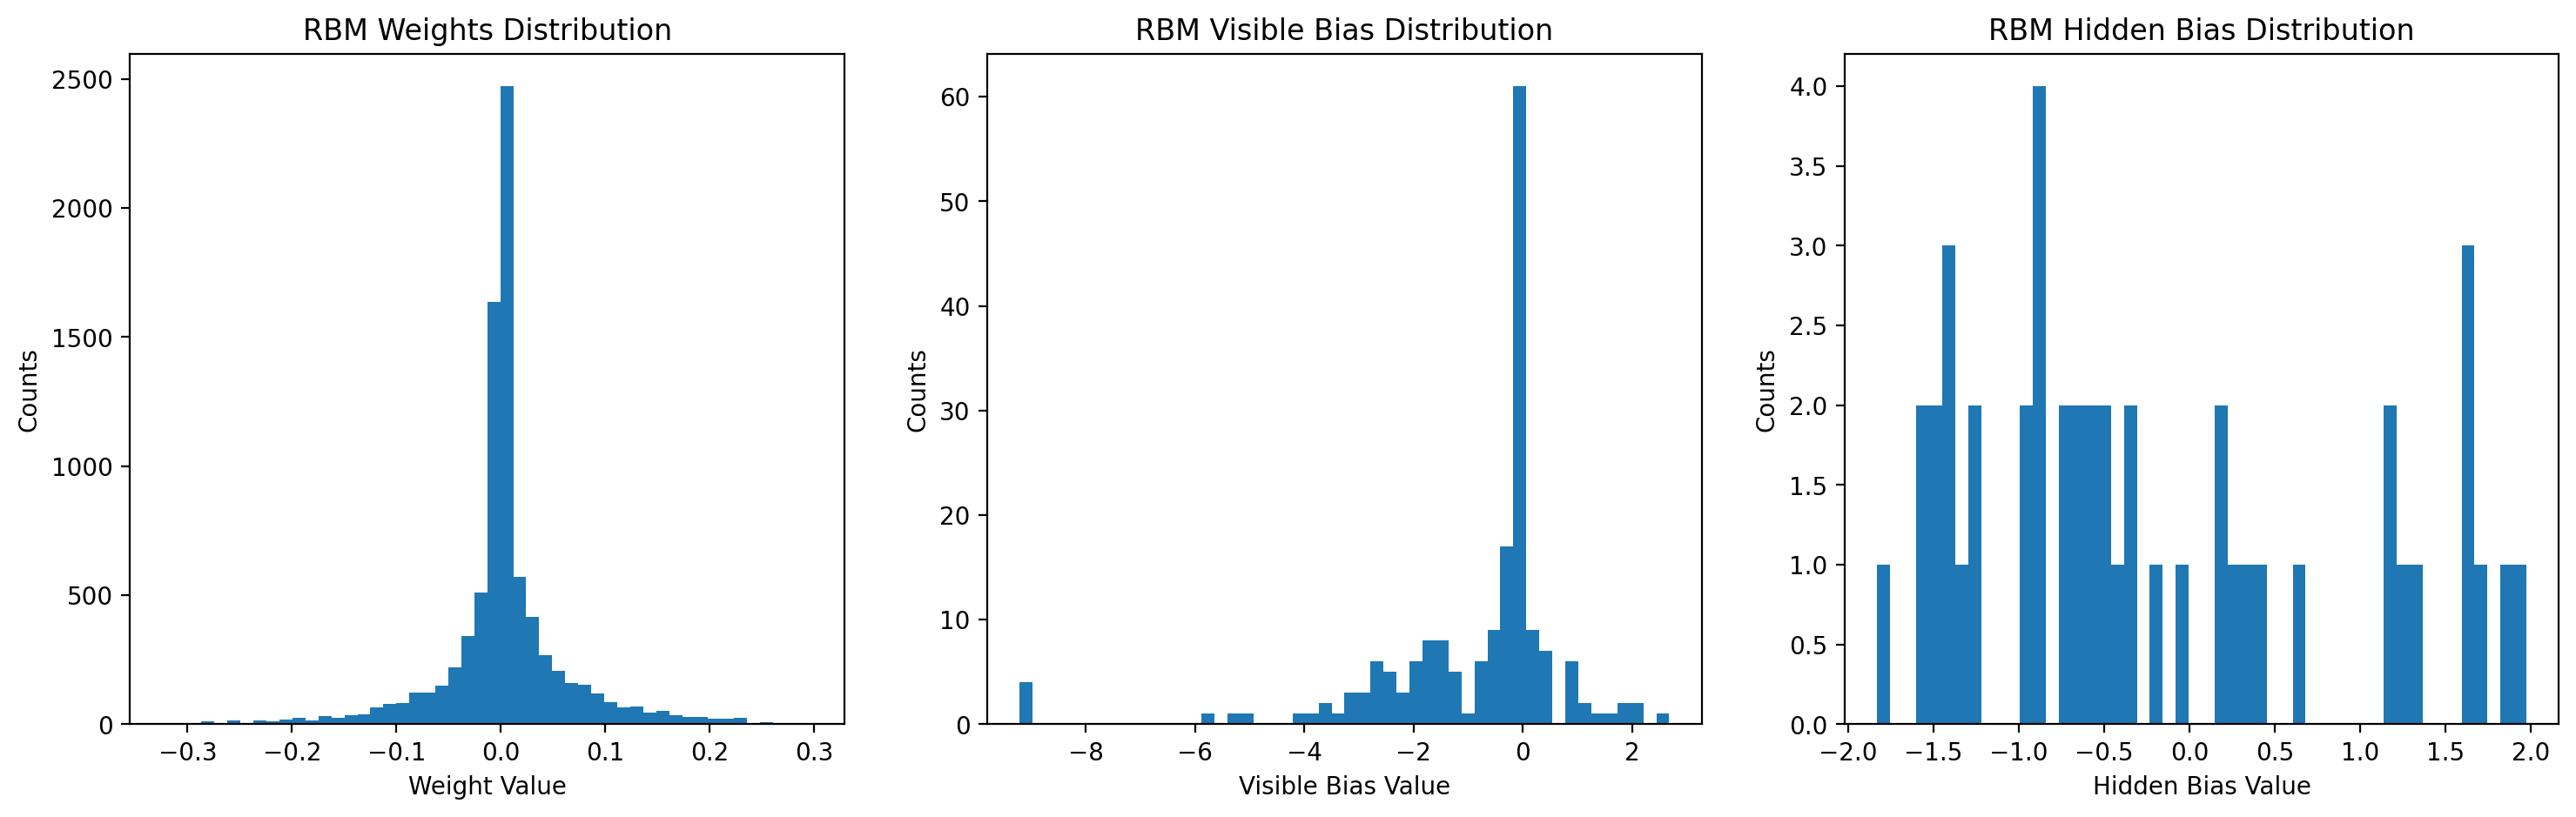

In [104]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].hist(rbm.params["weight_matrix"].cpu().numpy().flatten(), bins=50)
ax[0].set_title("RBM Weights Distribution")
ax[0].set_xlabel("Weight Value")
ax[0].set_ylabel("Counts")

ax[1].hist(rbm.params["vbias"].cpu().numpy().flatten(), bins=50)
ax[1].set_title("RBM Visible Bias Distribution")
ax[1].set_xlabel("Visible Bias Value")
ax[1].set_ylabel("Counts")

ax[2].hist(rbm.params["hbias"].cpu().numpy().flatten(), bins=50)
ax[2].set_title("RBM Hidden Bias Distribution")
ax[2].set_xlabel("Hidden Bias Value")
ax[2].set_ylabel("Counts")
plt.show()

In [105]:
print(rbm_samples.shape)
self.post_samples.shape
# rbm.params["weight_matrix"]
# post_hs.shape

torch.Size([50000, 230])


torch.Size([14999, 184])

In [106]:
def enLand(x,y,a,b,l,idx):
    return -x*a[idx]-y*b[idx]-l[idx]*x*y

beta=1.0
p_h = torch.sigmoid(beta * (rbm.params["hbias"].detach().cpu() + 
                            self.post_samples @ rbm.params["weight_matrix"].detach().cpu()))
post_hs = torch.bernoulli(p_h)

F = torch.linalg.svd(rbm.params["weight_matrix"].detach())
a0 = F[0].T @ rbm.params["vbias"].detach()
b0 = F[2] @ rbm.params["hbias"].detach()
l = F[1].detach()
u = F[0].T.detach().cpu() @ rbm_samples[:,:4*config.rbm.latent_nodes_per_p].T
w = F[2].detach().cpu() @ rbm_samples[:,4*config.rbm.latent_nodes_per_p:].T
u_post = F[0].T.detach().cpu() @ self.post_samples.T
w_post = F[2].detach().cpu() @ post_hs.T



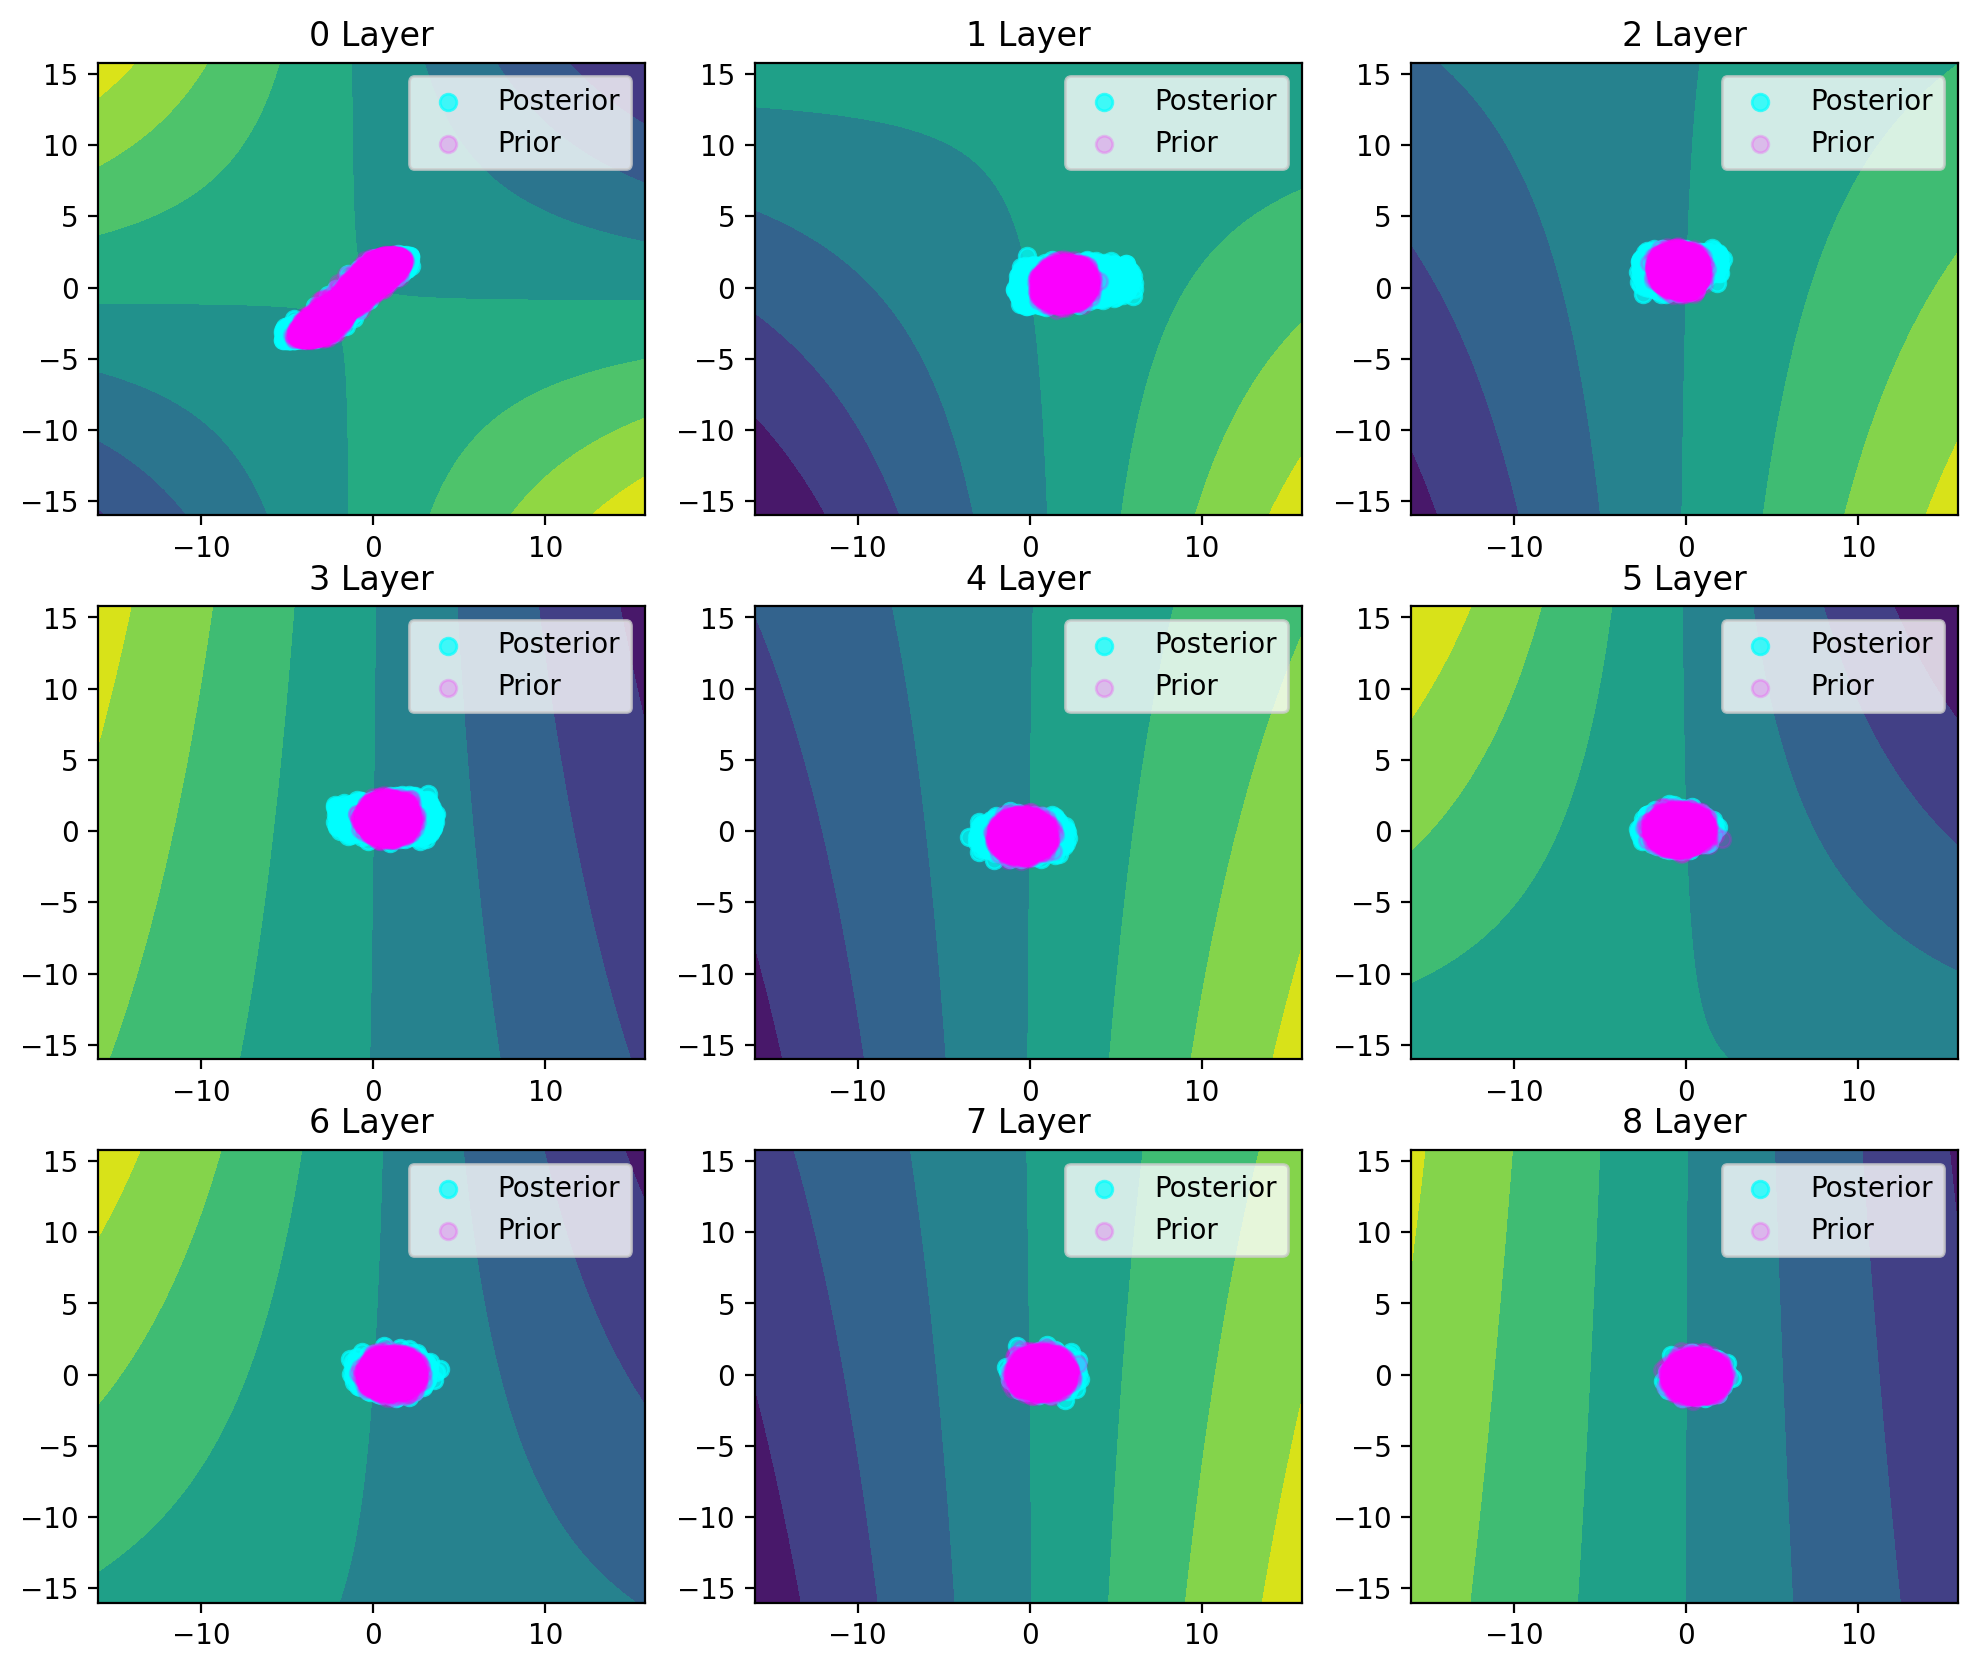

In [107]:
idx=0
fig, ax = plt.subplots(3,3, figsize=(12,10))

for i in [0,1,2]:
    for j in [0,1,2]:
        xmin =-15# torch.min(torch.tensor([u_post[idx,:].min(),u[idx,:].min()]))
        xmax = 15 #torch.max(torch.tensor([u_post[idx,:].max(),u[idx,:].max()]))
        ymin = -15 #torch.min(torch.tensor([w_post[idx,:].min(),w[idx,:].min()]))
        ymax = 15 #torch.max(torch.tensor([w_post[idx,:].max(),w[idx,:].max()]))
        delta = min((xmax - xmin)/100., (ymax - ymin)/100.)
        x = torch.arange(xmin-1, xmax+1, delta)
        y = torch.arange(ymin-1, ymax+1, delta)
        X, Y = torch.meshgrid(x, y)
        Z = enLand(X, Y, a0.cpu(), b0.cpu(), l.cpu(), idx)
        CS = ax[i, j].contourf(X, Y, Z)
        ax[i, j].scatter(u_post[idx,:].cpu(), w_post[idx,:].cpu(), alpha=0.7, c='cyan', label='Posterior')
        ax[i, j].scatter(u[idx,:].cpu(), w[idx,:].cpu(), alpha=0.2, c='magenta', label='Prior')
        ax[i, j].set_title(f'{idx} Layer')
        ax[i, j].legend()
        idx+=1

    

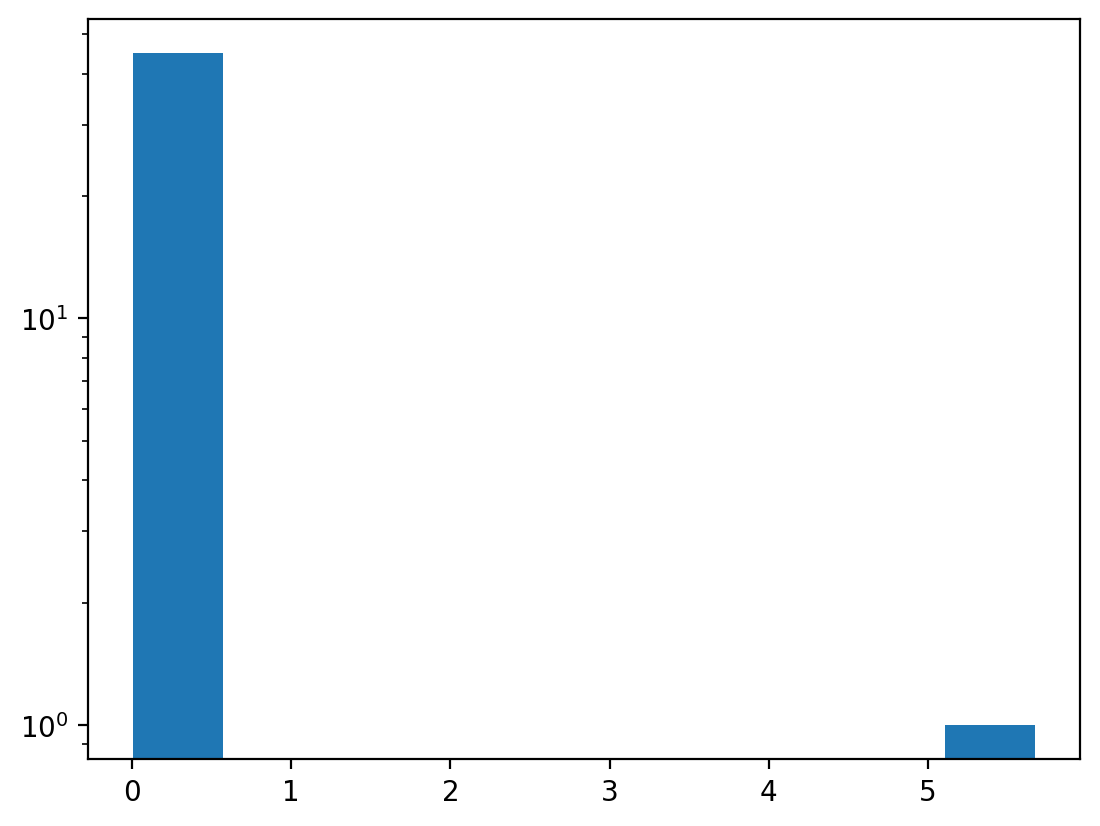

In [110]:
# plt.hist(l.detach().cpu().numpy(), bins=50)
# l.sort()
plt.hist(l.detach().cpu().numpy())
plt.yscale('log')
# plt.xscale('log')
plt.show()